# Robotic Arm - Panda Gym 

In [1]:
import numpy as np
import gymnasium as gym
import panda_gym
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch

from ddpg_algo import DDPGTrainer

* Robot: Simulates the Franka Emika Panda robotic arm for manipulation tasks.
<br>

* Observation Space:
    - All tasks include gripper position and velocity (6 values).
    - Tasks involving objects include their position, orientation, and velocities (linear and rotational, 12 values per object).
    - Gripper opening (distance between fingers) is included if not constrained closed (1 value).

* Action Space:
    - Gripper movement commands (3 values for x, y, and z axes).
    - Gripper opening/closing command (1 value).
    
* Simulation Details:
    - Simulation runs 20 timesteps per agent action (2ms each).
    - Overall interaction frequency is 25Hz.
    - Most tasks have episodes lasting 2 seconds (50 interactions).
    
* Reward Function:
    - Default reward is sparse: 0 for successful completion (within 5cm tolerance), -1 otherwise.
    - Sparse rewards are simpler to define but lack information on progress.

# PandaReach-v3

* Task: A target position must be reached with the gripper. This target position is randomly generated in a volume of 30 cm × 30 cm × 30 cm

In [2]:
env = gym.make(
    "PandaReach-v3",
    render_mode="rgb_array",
    renderer="OpenGL",
    render_target_position=[0, 0.15, 0.25],
    render_distance=0.85,
    render_yaw=135,
    render_pitch=-20,
)

pybullet build time: Nov 28 2023 23:45:17



Observation Space: Dict('achieved_goal': Box(-10.0, 10.0, (3,), float32), 'desired_goal': Box(-10.0, 10.0, (3,), float32), 'observation': Box(-10.0, 10.0, (6,), float32))

Action Space:  Box(-1.0, 1.0, (3,), float32)

Initial State:  ({'observation': array([ 3.8439669e-02, -2.1944723e-12,  1.9740014e-01,  0.0000000e+00,
       -0.0000000e+00,  0.0000000e+00], dtype=float32), 'achieved_goal': array([ 3.8439669e-02, -2.1944723e-12,  1.9740014e-01], dtype=float32), 'desired_goal': array([0.08827177, 0.00960147, 0.13252902], dtype=float32)}, {'is_success': array(False)})

A step in the environment:  ({'observation': array([0.05612974, 0.02471757, 0.20918499, 0.54309   , 1.1585152 ,
       0.51952785], dtype=float32), 'achieved_goal': array([0.05612974, 0.02471757, 0.20918499], dtype=float32), 'desired_goal': array([0.08827177, 0.00960147, 0.13252902], dtype=float32)}, -1.0, False, False, {'is_success': False})


Rendered Environment: 


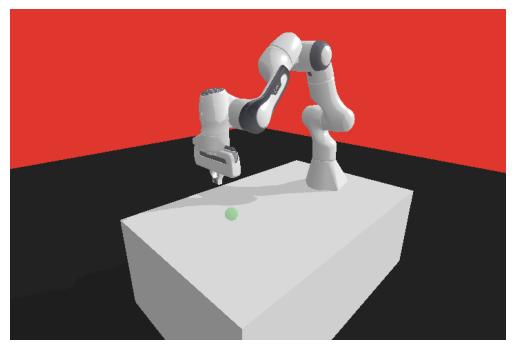

In [3]:
print('\nObservation Space:', env.observation_space)
print('\nAction Space: ', env.action_space)
print('\nInitial State: ',env.reset())
print('\nA step in the environment: ', env.step(np.array(1.0)))
print('\n\nRendered Environment: ')
env.reset()
plt.axis('off')
plt.imshow(env.render())
plt.show()

In [4]:
obs_shape = env.observation_space['observation'].shape[0] + \
            env.observation_space['achieved_goal'].shape[0] + \
            env.observation_space['desired_goal'].shape[0]

# Training - Obtain Expert Policy

1. **Initialization**:
   - Set hyperparameters, and initialize actor annd critic networks.
   - Initialize replay buffer memory.

2. **Training Loop**:
   - Loop through a specified number of episodes:
     - Reset the environment to get the initial observation.
     - While the episode is not done:
       - Select an action using the actor network with exploration noise.
       - Execute the action in the environment and observe the next state and reward.
       - Store the experience (state, action, reward, next_state, done) in the replay buffer.
       - Perform HER augmentation on the replay buffer.
       - Sample a batch of experiences from the replay buffer.
       - Optimize the critic network:
         - Compute target Q-values using the target critic networks.
         - Compute critic loss and perform gradient descent.
       - Update the actor network:
         - Compute actor loss and perform gradient descent.
       - Update the target critic network using a soft update rule.

3. **HER Augmentation**:
   - For each sample in the replay buffer, apply Hindsight Experience Replay by randomly sampling future states and goals.
   - Store the augmented experiences in the replay buffer.

4. **Optimize Model**:
   - If enough experiences are available in the replay buffer:
     - Sample a batch of experiences.
     - Compute target Q-values for both critic networks.
     - Compute critic loss and perform gradient descent.
     - Compute actor loss and perform gradient descent.
     - Update the target actor network.
     - Update the target critic network.

In [7]:
expert = DDPGTrainer(env=env, input_dims=obs_shape, agent_name='Expert', model_save_path='./Models/Expert/', 
                    exploration_period=200)

Training..:  20%|█████▉                       | 102/500 [00:11<00:41,  9.55it/s]

Episode: 100 	 Steps: 50 	 Score: -50.0 	 Average score: -34.0


Training..:  41%|███████████▊                 | 204/500 [00:18<00:17, 16.45it/s]

Episode: 200 	 Steps: 2 	 Score: -1.0 	 Average score: -5.9


Training..:  61%|█████████████████▌           | 303/500 [00:25<00:11, 16.73it/s]

Episode: 300 	 Steps: 2 	 Score: -1.0 	 Average score: -2.1


Training..:  80%|███████████████████████▎     | 402/500 [00:31<00:05, 16.57it/s]

Episode: 400 	 Steps: 2 	 Score: -1.0 	 Average score: -2.0


Training..: 100%|█████████████████████████████| 500/500 [00:37<00:00, 13.33it/s]


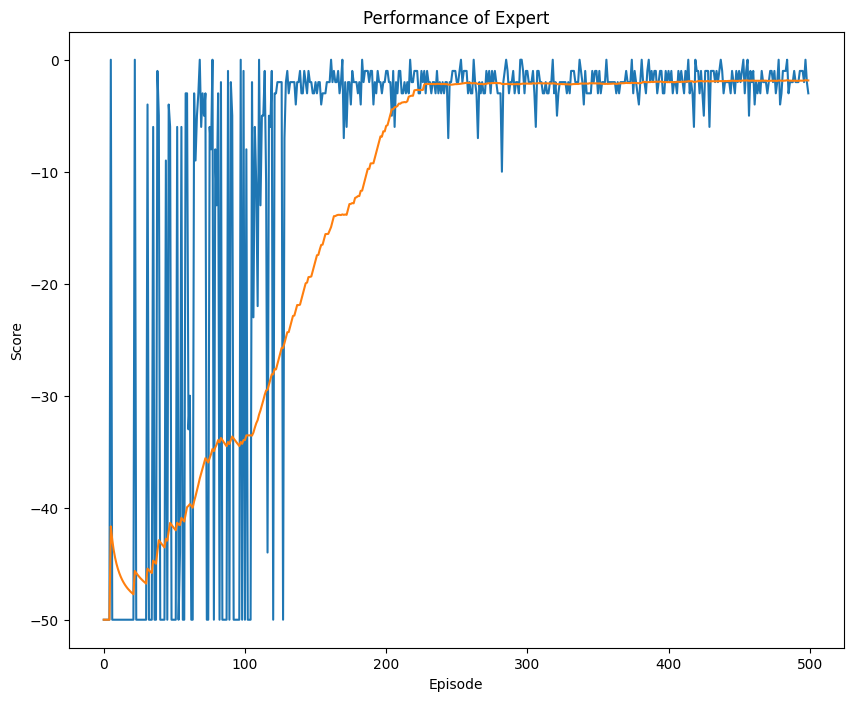

In [8]:
score_history, avg_score_history = expert.ddpg_train(n_episodes=500, opt_steps=10, print_every=100,
                                                    plot_save_path='../Results/DDPG/Expert Performance.png')

In [9]:
expert.save_model()

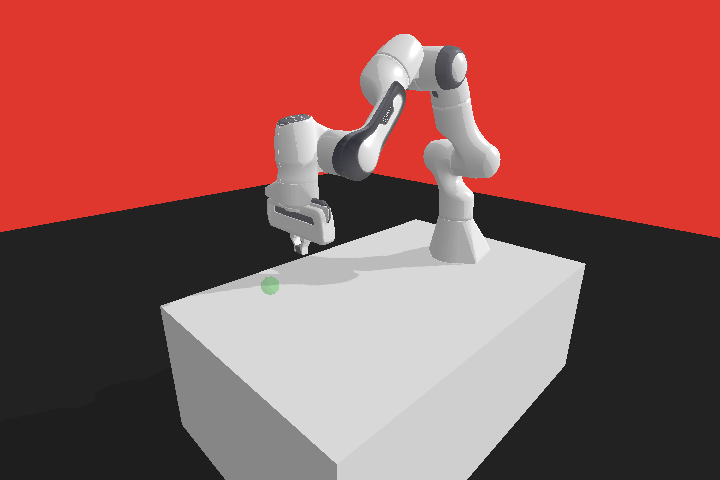

Expert Reward:  -2.0


In [10]:
expert_reward = expert.test_model(env=env, steps=100, render_save_path='../Results/DDPG/Expert Policy', fps=5)
print('Expert Reward: ', expert_reward)